## Notebook for Codereview 2

_This notebook is a part of the code review 2._

With this Notebook I want to introduce you to the system I have built.

This notebook requires you to have a HuggingFace API key. You can get one by signing up at [HuggingFace](https://huggingface.co/join).

### 1. Content Overview

The notebook is structured as follows:

1. [Content Overview](#1.-Content-Overview)
2. [Preparation](#2-preparation)
3. [QA-Generation](#3-QA-Generation)
4. [Retrieval](#4-retrieval)
5. [Visualization](#5-visualize-the-results)

### 2. Preparation
Before you can run the code, you need to do some preparation.

1. Prepare a OpenAI API key. (The costs of running will be between 1-5 cents)
2. Create a [Weights&Biases](https://wandb.ai/login) Account to additionally track the experiments on the Dashboard of Weights&Biases.

First we need to set the API Key for OpenAI. This key is stored on your local system using our SecretManager implementation which stores the key with an encryption key that is stored in your local system.

Run the coded below and you should be prompted to enter the api key if it is not already added to the secretmanager.

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sqa_system.core.data.secret_manager import SecretManager, EndpointType
secret_manager = SecretManager()
try:
    api_key = secret_manager.get_api_key(EndpointType.HUGGINGFACE)
    print("API Key found for HUGGINGFACE")
except ValueError as e:
    print("No API key found for HUGGINGFACE")
    api_key = input("No API key found for HUGGINGFACE. Enter your API Key: ")
    secret_manager.save_api_key(EndpointType.HUGGINGFACE, api_key)
    print("API Key saved successfully")

Rotating log file
API Key found for HUGGINGFACE


If you are running this code in a shared environment, it is also good practice to first check if the GPU is available and not currently in use. You can do this by running the cell below.

In [11]:
!nvidia-smi

Mon Feb 10 17:40:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100S-PCIE-32GB          On  |   00000000:D9:00.0 Off |                    0 |
| N/A   42C    P0             38W /  250W |    1600MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 3. QA-Generation

In the OpenAI notebook, at this point the QA-Generation would be showcased. However, unfortunately this is not possible with OpenSource models. We tried almost all of the newer models available on Ollama and None was able to generate an answer that conforms to the JSON format required.

We tried:
- llama3.3:70b
- phi4:14b
- qwq:32b
- llama3.1:8b
- mistral:7b
- qwen2.5:14b
- qwen2.5:32b

The highest model size we could try with the hardware that we have availalbe was 70b. I think the reason they are not returning is that the amount of parameters are not large enough to process the context window size that is required to process. As a result the following features are NOT working with open source models:
1. QA-Generation
2. Fulltext Extraction
3. Evaluation with RAGAS Framework

If you have ideas on how to solve this, your input is highly appreciated. For example you can look at our [Paper Content Extractor](../../sqa_system/core/data/extraction/paper_content_extractor.py) and [Ollama Adapter](../../sqa_system/core/language_model/implementations/ollama_llm_adapter.py).


Nevertheless I want to explain how the configuration system works.

A configuration is given as a json file. Every component in the framework has its own configuration files stored in the [data/configs](../../data/configs/) directory which are managed by the [ConfigurationManager](../../sqa_system/core/config/config_manager/implementations/) to distribute the configurations to the components.

The json files are validated when load by the Configuration Manager, however some complex configurations are only validated at a later stage when the components are created. 

Furthermore, because it is hard to know which values are valid without experience with the system (and because it has gotten quite complex), I have created a CLI tool that can be used to generate configurations. This tool is located [here](../../sqa_system/app/cli_controller.py) and should be run from console. 

As you can see below, this is how a configuration for a local RDFLIB graph looks like. The RDFLIB graph is a graph that is stored in memory using the RDFLib library which we will use for demonstration purposes. The configuration tells the framework, which graph to use and how it should be created.

For this codereview I have prepared a KG configuration for you. We will use this to create the graph and then generate questions and answers from it. This configuration is already prepared in the cache so using this **exact** configuration will not have any LLM calls during the generation of the graph.

In [3]:
# For the reason mentioned above we are using the OpenAI configuration below for the KG creation. Because the extraction is fully cached, we are not actually calling the OpenAI API. However, for the initialization we still need a key which is why we will add a dummy key here.
from sqa_system.core.data.secret_manager import SecretManager, EndpointType
secret_manager = SecretManager()
try:
    api_key = secret_manager.get_api_key(EndpointType.OPENAI)
    print("API Key found for OPENAI, but will not be used.")
except ValueError as e:
    print("No API key found for OPENAI. Adding dummy...")
    secret_manager.save_api_key(EndpointType.OPENAI, "DUMMY_KEY")

from sqa_system.core.config.models import KnowledgeGraphConfig
graph_config = {
    "additional_params": { # The building blocks that are used to generate the graph
        "building_blocks": [
            "metadata",
            "authors",
            "publisher",
            "venue",
            "research_field",
            "additional_fields",
            "annotations",
            "content"
        ]
    },
    "graph_type": "local_rdflib",   # We want to use a local graph using the RDFlib library
    "dataset_config": {     # This is a inner configuration that describes the dataset that will be used for the graph creation
        "additional_params": {},
        "file_name": "merged_ecsa_icsa.json",   # This is the file that contains the dataset data
        "loader": "JsonPublicationLoader",  # How the file will be loaded
        "loader_limit": 30  # We limit the number of publications for demonstration.
    },
    "extraction_llm": {    # This is the configuration for the LLM that will be used for extracting data from the dataset
            "additional_params": {},
            "endpoint": "OpenAI",
            "name_model": "gpt-4o-mini",
            "temperature": 0.1,
            "max_tokens": -1
    },
    "extraction_context_size": 2000
}
graph_config = KnowledgeGraphConfig.from_dict(graph_config)

# Some default configs are already prepared which can be loaded from the respective configuration manager by name
from sqa_system.core.config.models import LLMConfig
llm_config = LLMConfig.from_dict(
    {
            "additional_params": {},
            "endpoint": "Ollama",
            "name_model": "mistral",
            "temperature": 0.1,
            "max_tokens": 4096
    }
)

API Key found for OPENAI, but will not be used.


Running the code above initialized the Knowledge Graph configuration object. We can now use this configuration to create the graph by passing it to the `KnowledgeGraphManager`. This manager is responsible for creating the graph and storing it for the session to allow other parts of the system to access it.

The creation of the graph is a complex process including the steps:
1. Loading the Dataset
2. Extracting the Triples from the Dataset and tracing each triple to its origin
3. Creating the Graph using the triples

Because the creation is time consuming and if using a LLM like OpenAi can include costs, we cache each step using the [CacheManager](../../sqa_system/core/data/cache_manager.py) which stores the data in a SQLite database located in the [data/cache](../../data/cache) directory.

As mentioned above we already cached the data necessary for this configuration which means that the creation of the graph <u>has no further costs</u>.

In [4]:
# Here we create the graph
from sqa_system.knowledge_base.knowledge_graph.storage import KnowledgeGraphManager
graph = KnowledgeGraphManager().get_item(graph_config) 

# We also load the LLM model using the LLMProvider which is responsible for creating and preparing
# a LLM based on the configuration provided
from sqa_system.core.language_model.llm_provider import LLMProvider
llm_adapter = LLMProvider().get_llm_adapter(llm_config)

### 4. Retrieval
Now we start the experimentation. I have prepared several configurations for you to run and then visualize the results. We first have the HubLink Retrieval approach (our new approach) and then two baselines.

#### HubLink Retriever
Below I have prepared a configuration for you to run the HubLink Retrieval approach. This configuration is already indexed so the amount of LLM calls is minimized.

The retriever has several parameters that can be configured as you can see in the configuration below. These configs allow to reproduce the experiments and to test different configurations of the retriever. Hyperparameter optimization can also be done using the `parameter_ranges` field in the configuration.

Run the code below to prepare the configuration.

In [1]:
from sqa_system.core.config.models import ExperimentConfig
experiment_dict = {
    "additional_params": {},
    "base_pipeline_config": {
        "additional_params": {},
        "pipes": [
            {
                "additional_params": {
                    "embedding_config": {
                        "additional_params": {},
                        "endpoint": "HuggingFace",
                        "name_model": "mixedbread-ai/mxbai-embed-large-v1"
                    },
                    "max_workers": 8,
                    "number_of_hubs": 5,
                    "top_paths_to_keep": 10,
                    "run_indexing": True,
                    "indexing_root_entity_types": "",
                    "force_index_update": False,
                    "max_hub_path_length": 10,
                    "force_hub_update": False,
                    "hub_types": "",
                    "hub_edges": -1,
                    "use_topic_if_given": False,
                    "compare_hubs_with_same_hop_amount": True,
                    "max_level": 5,
                    "use_source_documents": True,
                    "source_vector_store_config": {
                        "additional_params": {
                            "distance_metric": "l2"
                        },
                        "vector_store_type": "chroma",
                        "chunking_strategy_config": {
                            "additional_params": {},
                            "chunking_strategy_type": "RecursiveCharacterChunkingStrategy",
                            "chunk_size": 500,
                            "chunk_overlap": 0
                        },
                        "embedding_config": {
                            "additional_params": {},
                            "endpoint": "HuggingFace",
                            "name_model": "mixedbread-ai/mxbai-embed-large-v1"
                        },
                        "dataset_config": {
                            "additional_params": {},
                            "file_name": "merged_ecsa_icsa.json",
                            "loader": "JsonPublicationLoader",
                            "loader_limit": 30
                        }
                    }
                },
                "type": "kg_retrieval",
                "retriever_type": "hublink",
                "llm_config": {
                    "additional_params": {},
                    "endpoint": "Ollama",
                    "name_model": "ollama run deepseek-r1:14b",
                    "temperature": 0.1,
                    "max_tokens": 4096
                },
                "knowledge_graph_config": {
                    "additional_params": {
                        "building_blocks": [
                            "metadata",
                            "authors",
                            "publisher",
                            "venue",
                            "research_field",
                            "additional_fields",
                            "annotations",
                            "content"
                        ]
                    },
                    "graph_type": "local_rdflib",
                    "dataset_config": {
                        "additional_params": {},
                        "file_name": "merged_ecsa_icsa.json",
                        "loader": "JsonPublicationLoader",
                        "loader_limit": 3
                    },
                    "extraction_llm": {
                        "additional_params": {},
                        "endpoint": "OpenAI",
                        "name_model": "gpt-4o-mini",
                        "temperature": 0.1,
                        "max_tokens": -1
                    }
                }
            },
            {
                "additional_params": {},
                "type": "generation",
                "llm_config": {
                    "additional_params": {},
                    "endpoint": "Ollama",
                    "name_model": "ollama run deepseek-r1:14b",
                    "temperature": 0.1,
                    "max_tokens": 4096
                }
            }
        ]
    },
    "parameter_ranges": [],
    "evaluators": [
                {
                    "name": "hit_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "hit_at_k"
                },
                {
                    "name": "hit_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "hit_at_k"
                },
                {
                    "name": "hit_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "hit_at_k"
                },
                {
                    "name": "map_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "map_at_k"
                },
                {
                    "name": "map_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "map_at_k"
                },
                {
                    "name": "mrr_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "mrr_at_k"
                },
                {
                    "name": "mrr_at_k",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "mrr_at_k"
                },
                {
                    "name": "basic_score",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "basic_score"
                },
                {
                    "name": "basic_score",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "basic_score"
                },
                {
                    "name": "basic_score",
                    "additional_params": {
                        "k": -1,
                        "context_type": "triple"
                    },
                    "evaluator_type": "basic_score"
                },
                {
                    "name": "basic_score",
                    "additional_params": {
                        "k": -1,
                        "context_type": "entity"
                    },
                    "evaluator_type": "basic_score"
                },
                {
                    "name": "exact_match",
                    "additional_params": {
                        "k": 10,
                        "context_type": "triple"
                    },
                    "evaluator_type": "exact_match"
                },
                {
                    "name": "exact_match",
                    "additional_params": {
                        "k": 10,
                        "context_type": "entity"
                    },
                    "evaluator_type": "exact_match"
                },
                {
                    "name": "exact_match",
                    "additional_params": {
                        "k": -1,
                        "context_type": "triple"
                    },
                    "evaluator_type": "exact_match"
                },
                {
                    "name": "exact_match",
                    "additional_params": {
                        "k": -1,
                        "context_type": "entity"
                    },
                    "evaluator_type": "exact_match"
                }
    ],
    "qa_dataset": {
        "additional_params": {},
        "file_name": "question_answering_codereview.csv",
        "loader": "CSVQALoader",
        "loader_limit": -1
    }
}
experiment_config = ExperimentConfig.from_dict(experiment_dict)

import os
from sqa_system.core.data.file_path_manager import FilePathManager

# Here we prepare the location where the results of the experiment will be stored
file_path_manager = FilePathManager()
current_directory = os.getcwd()
folder_path = file_path_manager.combine_paths(current_directory, "experiment_data_huggingface")
experiment_folder = file_path_manager.combine_paths(folder_path, experiment_config.base_pipeline_config.config_hash)
print(f"Results will be stored in {experiment_folder}")

Results will be stored in /home/jovyan/work/master_thesis_implementation/sqa-system/notebooks/codereview/experiment_data_huggingface/504d82f7874f704563cf731340b97c80


Now we can use the configuration to run the experiment. The experiment runner will use the configuration to create the retriever, load the QAPairs and run the experiment. 

The indexing process for this configuration has already been done and should be cached.

In [2]:
from sqa_system.experimentation.experiment_runner import ExperimentRunner, ProgressHandler

# We can now run the experiment using the ExperimentRunner
runner = ExperimentRunner(
    experiment_config=experiment_config,
    results_folder_path=experiment_folder,
)
results = runner.run()
results.head()

Running Experiments...                                                                 ━━━━━━━━━━━━━━━   0% -:--:--
Asking Questions...                                                                    ━━━━━━━━━━━━━━━   0% -:--:--
Running pipeline                                                                       ━━━━━━━━━━━━━━━   0% -:--:--
Processing Hubs...                                                                     ━━━━━━━━━━━━━━━   0% -:--:--
Converting Hub Paths for http://ressource.org/publication/10.1109/ICSA47634.2020.00016 ━━━━━━━━━━━━━━━   0% -:--:--
Converting Hub Paths for http://ressource.org/publication/10.1109/ICSA.2017.32         ━━━━━━━━━━━━━━━   0% -:--:--
Converting Hub Paths for http://ressource.org/publication/10.1007/978-3-030-00761-4_2  ━━━━━━━━━━━━━━━   0% -:--:--
Converting Hub Paths for http://ressource.org/publication/10.1109/ICSA.2019.00009      ━━━━━━━━━━━━━━━   0% -:--:--
Converting Hub Paths for http://ressource.org/publication/10.1007/978-3-030-29983-5_4  ━━━━━━━━━━━━━━━   0% -:--:--

OpCallError: 
Call error: Error calling HitAtKEvaluator.score: missing a required argument: 'self'

                    If using the `Scorer` weave class, you can set the `scorer.column_map`
attribute to map scorer argument names to dataset columns.

For example, if the `score` expects "output", "input" and "ground_truth" and we have a dataset
with columns "question" and "answer", `column_map` can be used to map the non-output parameter like so:
{"input": "question", "ground_truth": "answer"}

scorer argument names: ['output', 'golden_answer', 'golden_triples', 'golden_doc_chunks']
dataset keys: <generator object WeaveDict.keys at 0x7f7d04529630>
scorer.column_map: None

Options for resolving:
a. if using the `Scorer` weave class, you can set the `scorer.column_map` attribute to map scorer argument names to dataset column names or
b. change the argument names the in the scoring function of HitAtKEvaluator_triple to match a subset of dataset column names: (uid, question, golden_answer, ...) or
c. change dataset column names to match expected HitAtKEvaluator_triple argument names: []


Great, now that the experiment finished, the results are stored in the experiment_data folder in the same folder of this notebook. This folder is generated by the experiment runner and contains 3 subfolders.
1. configs: Contains the configuration(s) that have been used to run the experiment. This allows to check the configuration that was used for the experiment at any point at a later time. 
2. predictions: This includes the predictions stored as `.csv` files. Feel free to look at the file and review if anything is missing.
3. visualizations: This folder contains visualizations done by the runner to get a feel for the performance of the retriever. These will not be the final visualizations but are helpful to get a quick overview of the performance.

### Baseline: DocumentEmbed Retriever
We need something to compare against so I also prepared two baselines for you. The first one is the DocumentEmbed Retriever. This retriever doesn't use a KG but instead directly embeds the fulltexts of the documents and stores them in a vector store. The retriever then uses the vector store to retrieve the most similar document to the question.

In [7]:
from sqa_system.core.config.config_manager import ExperimentConfigManager
experiment_config = ExperimentConfigManager().get_config_by_name("DocumentEmbed_Codereview_Huggingface")
experiment_folder = file_path_manager.combine_paths(folder_path, experiment_config.base_pipeline_config.config_hash)
print(f"Results will be stored in {experiment_folder}")

Results will be stored in /home/jovyan/work/master_thesis_implementation/sqa-system/notebooks/codereview/experiment_data_huggingface/2efc72ce08395f11d34a6bcff14c2656


In [8]:
from sqa_system.experimentation.experiment_runner import ExperimentRunner

# We can now run the experiment using the ExperimentRunner
runner = ExperimentRunner(
    experiment_config=experiment_config,
    results_folder_path=experiment_folder,
)
results = runner.run()
results.head()

Running Experiments... ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  50% -:--:--
Asking Questions...    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

🍩 https://wandb.ai/marco_kit/ma_mschneider_experiment_run/r/call/019456d5-e9c8-78a2-abad-d31316911bb5

/home/jovyan/work/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:265: UserWarning: The palette list has more values (11) than needed (1), which may not be intended.
  sns.boxplot(data=melted_data, x='Metric', y='Value', hue='config_hash', palette=COLOR_LIST)
/home/jovyan/work/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:295: UserWarning: The palette list has more values (11) than needed (1), which may not be intended.
  sns.barplot(x='Metric', y='Average Score', hue='config_hash',


,config_hash,uid,question_result,golden_answer_result,golden_triples_result,topic_entity_id_result,topic_entity_value_result,is_generated_with_result,knowledge_representation_type_result,question_type_result,...,topic_entity_id_question,knowledge_representation_type_question,question_type_question,question_type_reasoning_question,answer_type_question,answer_type_reasoning_question,information_type_question,topic_entity_value_question,hop_amount_question,based_on_template_question
0,2efc72ce08395f11d34a6bcff14c2656,66ce430a-6ce6-490f-8f75-ec8d260d72b6,Which publications discuss the research topic ...,The publications that discuss the research obj...,[(Determination and Enforcement of Least-Privi...,None,None,clustering_strategy,None,['String Operation'],...,None,None,['String Operation'],String Operation is appropriate because the qu...,['Research'],The question seeks information about publicati...,None,None,None,None
1,2efc72ce08395f11d34a6bcff14c2656,1861831e-094b-41e1-a26c-78a2b3d79fbc,Which publications discuss the concept of refe...,The publications that discuss the concept of R...,[(Updating Service-Based Software Systems in A...,None,None,clustering_strategy,None,"['String Operation', 'List/Combine']",...,None,None,"['String Operation', 'List/Combine']",String Operation is appropriate because the qu...,"['Concept', 'Research']",The question is asking about publications that...,None,None,None,None
2,2efc72ce08395f11d34a6bcff14c2656,50527f73-7896-43ad-8a15-6b9c613a402e,Which publications discuss the concept of Arch...,The publications that discuss the concept of A...,[(Data-Driven Software Architecture for Analyz...,None,None,clustering_strategy,None,['String Operation'],...,None,None,['String Operation'],String Operation is appropriate because the qu...,"['Description', 'Concept', 'Research']",The question seeks to identify publications th...,None,None,None,None
3,2efc72ce08395f11d34a6bcff14c2656,d56ba8f9-44c8-4900-a4bb-27ef65cb9594,Which publications discuss architectural aspec...,The publications that discuss architectural as...,[(An Architectural View for Data Protection by...,None,None,clustering_strategy,None,"['List/Combine', 'String Operation']",...,None,None,"['List/Combine', 'String Operation']",List/Combine is appropriate because the questi...,"['Research', 'Concept', 'Procedure']",The question seeks to identify publications th...,None,None,None,None
4,2efc72ce08395f11d34a6bcff14c2656,7077bd9f-00dd-41a0-a8e9-352c27545e2a,Which publications discuss the architecture de...,The following publications discuss the Archite...,[(Microservice Ambients: An Architectural Meta...,None,None,clustering_strategy,None,['String Operation'],...,None,None,['String Operation'],String Operation is appropriate because the qu...,"['Methodology', 'Research']",The question seeks information about publicati...,None,None,None,None


### Baseline: TripleEmbed Retriever
The second baseline is the TripleEmbed Retriever. This retriever uses the triples of the graph and embeds them. The retriever then uses the vector store to retrieve the most similar triple to the question.

In [9]:
from sqa_system.core.config.config_manager import ExperimentConfigManager
experiment_config = ExperimentConfigManager().get_config_by_name("TripleEmbed_Codereview_Huggingface")
experiment_folder = file_path_manager.combine_paths(folder_path, experiment_config.base_pipeline_config.config_hash)
print(f"Results will be stored in {experiment_folder}")

Results will be stored in /home/jovyan/work/master_thesis_implementation/sqa-system/notebooks/codereview/experiment_data_huggingface/4faa17a56d67707f248ce2e9b1122503


In [2]:
from sqa_system.experimentation.experiment_runner import ExperimentRunner

# We can now run the experiment using the ExperimentRunner
runner = ExperimentRunner(
    experiment_config=experiment_config,
    results_folder_path=experiment_folder,
)
results = runner.run()
results.head()

Rotating log file
Logged in as Weights & Biases user: marco_kit.
View Weave data at https://wandb.ai/marco_kit/ma_mschneider_experiment_run/weave


Output()

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluated 1 of 5 examples

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluated 2 of 5 examples

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluated 3 of 5 examples

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluated 4 of 5 examples

Evaluating:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluated 5 of 5 examples

Evaluation summary
{
    'RagasEvaluator': {
        'non_llm_string_similarity': {'mean': 0.182},
        'answer_relevancy': {'mean': 0.586},
        'semantic_similarity': {'mean': 0.892},
        'llm_context_precision_without_reference': {'mean': 1.0},
        'rouge_score': {'mean': 0.22200000000000003},
        'llm_context_precision_with_reference': {'mean': 0.9440000000000002},
        'bleu_score': {'mean': 0.076},
        'row_scores': [
            {
                'llm_context_precision_with_reference': 0.91,
                'llm_context_precision_without_reference': 1.0,
                'answer_relevancy': 0.98,
                'semantic_similarity': 0.9,
                'non_llm_string_similarity': 0.12,
                'bleu_score': 0.05,
                'rouge_score': 0.18
            },
            {
                'llm_context_precision_with_reference': 0.9,
                'llm_context_precision_without_reference': 1.0,
                'answer_relevancy': 0.99,
                'semantic_similarity': 0.9,
                'non_llm_string_similarity': 0.17,
                'bleu_score': 0.06,
                'rouge_score': 0.23
            },
            {
                'llm_context_precision_with_reference': 1.0,
                'llm_context_precision_without_reference': 1.0,
                'answer_relevancy': 0.0,
                'semantic_similarity': 0.85,
                'non_llm_string_similarity': 0.19,
                'bleu_score': 0.05,
                'rouge_score': 0.2
            },
            {
                'llm_context_precision_with_reference': 0.97,
                'llm_context_precision_without_reference': 1.0,
                'answer_relevancy': 0.96,
                'semantic_similarity': 0.93,
                'non_llm_string_similarity': 0.24,
                'bleu_score': 0.12,
                'rouge_score': 0.25
            },
            {
                'llm_context_precision_with_reference': 0.94,
                'llm_context_precision_without_reference': 1.0,
                'answer_relevancy': 0.0,
                'semantic_similarity': 0.88,
                'non_llm_string_similarity': 0.19,
                'bleu_score': 0.1,
                'rouge_score': 0.25
            }
        ]
    },
    'EntityPresence': {
        'entity_presence': {'mean': 1.0},
        'row_scores': [
            {'entity_presence': 1.0},
            {'entity_presence': 1.0},
            {'entity_presence': 1.0},
            {'entity_presence': 1.0},
            {'entity_presence': 1.0}
        ]
    },
    'TriplePresence': {
        'triple_presence': {'mean': 0.0},
        'row_scores': [
            {'triple_presence': 0.0},
            {'triple_presence': 0.0},
            {'triple_presence': 0.0},
            {'triple_presence': 0.0},
            {'triple_presence': 0.0}
        ]
    },
    'HitAtKEvaluator': {
        'hit@10': {'mean': 0.0},
        'row_scores': [{'hit@10': 0}, {'hit@10': 0}, {'hit@10': 0}, {'hit@10': 0}, {'hit@10': 0}]
    },
    'model_latency': {'mean': 40.93480911254883}
}

🍩 https://wandb.ai/marco_kit/ma_mschneider_experiment_run/r/call/01945709-a0e1-7e81-8be5-5fd8d35def69

/home/jovyan/work/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:265: UserWarning: The palette list has more values (11) than needed (1), which may not be intended.
  sns.boxplot(data=melted_data, x='Metric', y='Value', hue='config_hash', palette=COLOR_LIST)
/home/jovyan/work/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:295: UserWarning: The palette list has more values (11) than needed (1), which may not be intended.
  sns.barplot(x='Metric', y='Average Score', hue='config_hash',


,config_hash,uid,question_result,golden_answer_result,golden_triples_result,topic_entity_id_result,topic_entity_value_result,is_generated_with_result,knowledge_representation_type_result,question_type_result,...,topic_entity_id_question,knowledge_representation_type_question,question_type_question,question_type_reasoning_question,answer_type_question,answer_type_reasoning_question,information_type_question,topic_entity_value_question,hop_amount_question,based_on_template_question
0,a7687c78bda324f1d0d15233073db0b2,66ce430a-6ce6-490f-8f75-ec8d260d72b6,Which publications discuss the research topic ...,The publications that discuss the research obj...,[(Determination and Enforcement of Least-Privi...,None,None,clustering_strategy,None,['String Operation'],...,None,None,['String Operation'],String Operation is appropriate because the qu...,['Research'],The question seeks information about publicati...,None,None,None,None
1,a7687c78bda324f1d0d15233073db0b2,1861831e-094b-41e1-a26c-78a2b3d79fbc,Which publications discuss the concept of refe...,The publications that discuss the concept of R...,[(Updating Service-Based Software Systems in A...,None,None,clustering_strategy,None,"['String Operation', 'List/Combine']",...,None,None,"['String Operation', 'List/Combine']",String Operation is appropriate because the qu...,"['Concept', 'Research']",The question is asking about publications that...,None,None,None,None
2,a7687c78bda324f1d0d15233073db0b2,50527f73-7896-43ad-8a15-6b9c613a402e,Which publications discuss the concept of Arch...,The publications that discuss the concept of A...,[(Data-Driven Software Architecture for Analyz...,None,None,clustering_strategy,None,['String Operation'],...,None,None,['String Operation'],String Operation is appropriate because the qu...,"['Description', 'Concept', 'Research']",The question seeks to identify publications th...,None,None,None,None
3,a7687c78bda324f1d0d15233073db0b2,d56ba8f9-44c8-4900-a4bb-27ef65cb9594,Which publications discuss architectural aspec...,The publications that discuss architectural as...,[(An Architectural View for Data Protection by...,None,None,clustering_strategy,None,"['List/Combine', 'String Operation']",...,None,None,"['List/Combine', 'String Operation']",List/Combine is appropriate because the questi...,"['Research', 'Concept', 'Procedure']",The question seeks to identify publications th...,None,None,None,None
4,a7687c78bda324f1d0d15233073db0b2,7077bd9f-00dd-41a0-a8e9-352c27545e2a,Which publications discuss the architecture de...,The following publications discuss the Archite...,[(Microservice Ambients: An Architectural Meta...,None,None,clustering_strategy,None,['String Operation'],...,None,None,['String Operation'],String Operation is appropriate because the qu...,"['Methodology', 'Research']",The question seeks information about publicati...,None,None,None,None


### Visualize the Results
We can also visualize the results using the `ExperimentVisualizer`. This visualizer provides several plots to compare the performances of the retrievers. It is provided with a folder path and searches the folder path for valid prediction files by crawling through the subfolders. It then matches the questions by their ID and the unique ID of the configuration to generate the plot.

This is why you only see a long hash ID in the plot. For each configuration a unique hash is generated. This means that if we change even a single parameter in the config, its ID will change which makes it easy when comparing different configurations. It also makes sure that if we by chance run the same configuration twice, we can recognize this by the ID.

To find out what ID constitutes to what configuration, we can look at the results folder `experiment_data` and find the configuration file that was used for the experiment.

Looking at the results, it is expected that the baselines are close to the retrieval performance of our retriever. This is because of several reasons. 
1. The question types generated with the generator we used
2. The low amount of data that we used

/home/jovyan/work/master_thesis_implementation/sqa-system/sqa_system/experimentation/utils/experiment_visualizer.py:295: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.barplot(x='Metric', y='Average Score', hue='config_hash',


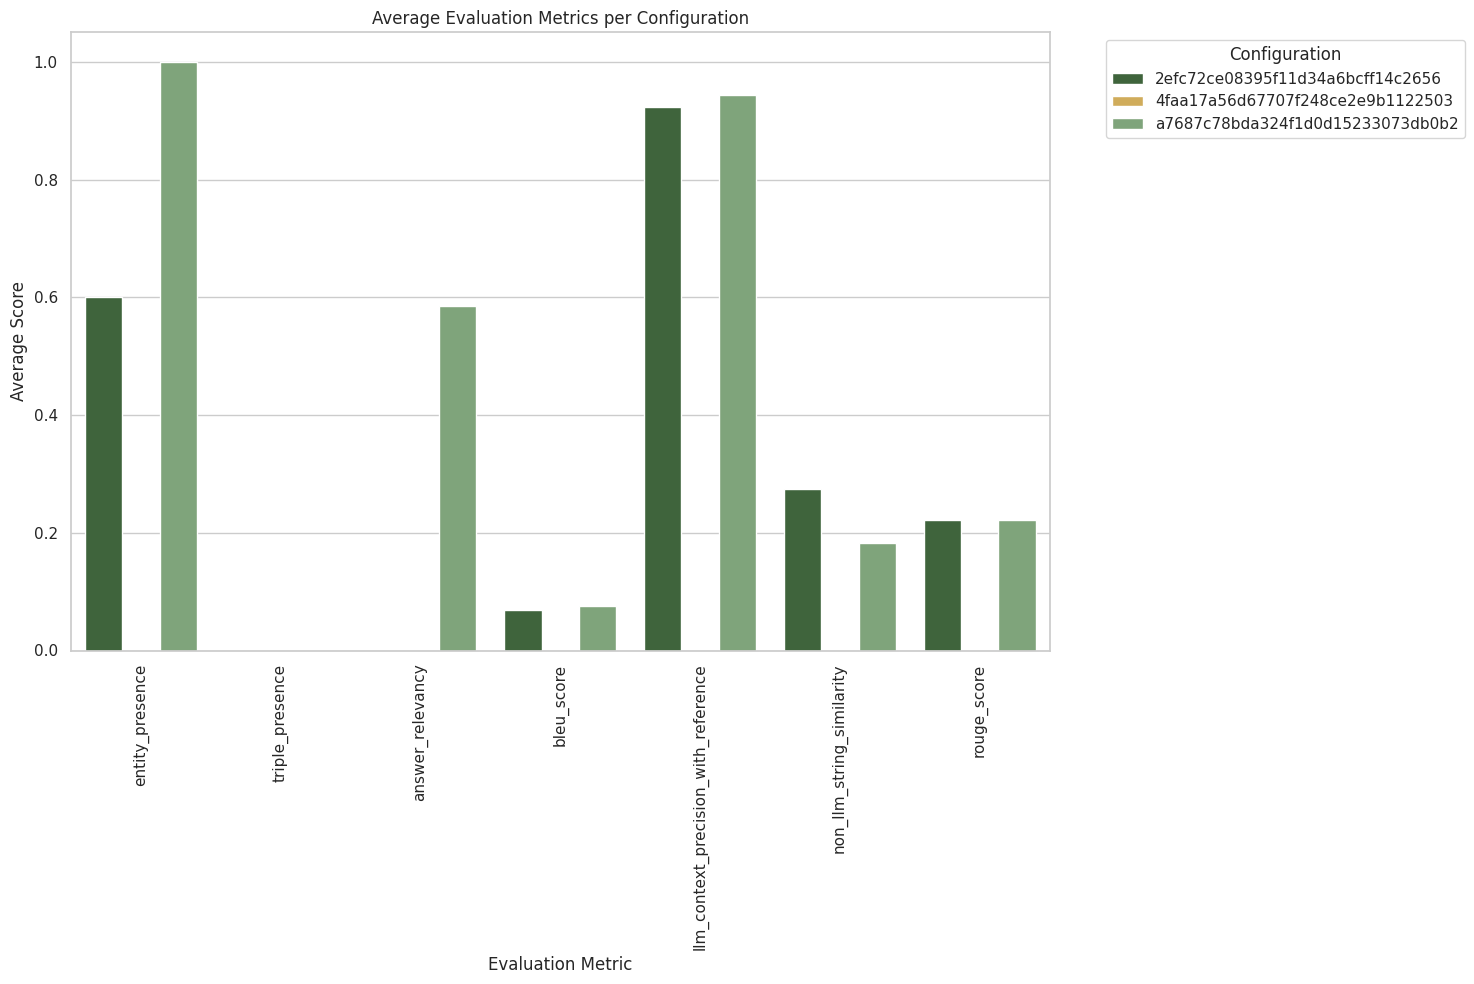

In [3]:
from sqa_system.experimentation.utils.visualizer.experiment_visualizer import ExperimentVisualizer, PlotType
visualizer = ExperimentVisualizer(
    data_folder_path=folder_path,
    should_print=True,
    should_save_to_file=False,
)
visualizer.run(plots_to_generate=[PlotType.AVERAGE_METRICS_PER_CONFIG])